In [3]:
import torch
import numpy as np
import pickle

In [5]:
a = pickle.load(open('train_mfcc.dump', 'rb'))
len(a)

1014

In [6]:
def make_chunks(mfccs, labels, window_size=256, stride=128):
    chunk = []
    chunk_labels = []
    for mfcc, label in zip(mfccs, labels):
        # (W - F + 2P)/S + 1
        for start in range(0, int((mfcc.shape[1] - window_size)/stride)+1): 
            chunk.append(mfcc[:, start * stride:(start * stride + window_size)])
            chunk_labels.append(label)
    return(chunk, chunk_labels)

train_Y, test_Y = pickle.load(open('train_labels.dump', 'rb'))
train_X = pickle.load(open('train_mfcc.dump', 'rb'))
test_X = pickle.load(open('test_mfcc.dump', 'rb'))

train_X, train_Y = make_chunks(train_X, train_Y)
test_X, test_Y = make_chunks(test_X, test_Y)
train_X = np.array(train_X)
test_X =  np.array(test_X)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

train_X = train_X.reshape([train_X.shape[0], -1])
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [9]:
test_X = test_X.reshape([test_X.shape[0], -1])
test_X = scaler.transform(test_X)

y_pred = classifier.predict(test_X)

In [10]:
np.sum(np.equal(y_pred, test_Y)) / len(test_Y)

0.36881625441696114

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1345b1d90>)

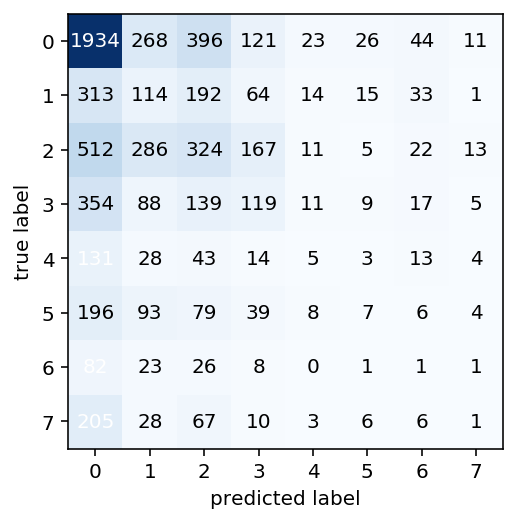

In [12]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confMatrix = confusion_matrix(test_Y, y_pred)
plot_confusion_matrix(confMatrix)


### Fisher's LDA

In [13]:
x_train = train_X
y_train = train_Y

In [14]:
from scipy.linalg import eig

SW = 0
SB = 0
mu = np.mean(x_train, axis = 0)

for i in range(8):
    x_slice = x_train[y_train == i,:]
    mu_i = np.mean(x_slice, axis = 0)
    x_slice -= mu_i
    SW += x_slice.T @ x_slice
    SB += x_slice.shape[0] * np.outer(mu_i-mu, mu_i-mu)
    
eigenval, eigenvec = eig(SB, SW)
idx = eigenval.argsort()[::-1]
A = np.real(eigenvec[:, idx])[:,:100]
x_lowDim = x_train @ A

In [15]:
x_train.shape

(26788, 3328)

In [16]:
x_lowDim.shape

(26788, 100)

#### svm

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf_SVC = SVC(gamma='scale')
clf_SVC.fit(x_train, y_train)
y_pred_SVC = clf_SVC.predict(test_X)
print('Accuracy for SVM: ' + str(accuracy_score(test_Y, y_pred_SVC)))


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf_SVC = SVC(gamma='scale')
clf_SVC.fit(x_lowDim, y_train)
y_pred_SVC = clf_SVC.predict(test_X @ A)
print('Accuracy for SVM: ' + str(accuracy_score(test_Y, y_pred_SVC)))

#### knn

### CNN

In [3]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = torch.from_numpy(data).float()
        self.label = torch.from_numpy(label).long()
        self.transform = transform
        
    def __getitem__(self, index:int):
        x = self.data[index]
        y = self.label[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x[np.newaxis, ...], y
    
    def __len__(self):
        return len(self.data)

dataset = MyDataset(train_X, train_Y)
loader =  DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available()
)

idx, (data, label) = next(enumerate(loader))
print(data.shape)
print(label)
#for batch_idx, (data, target) in enumerate(loader):
    #print('Batch idx {}, data shape {}, target shape {}'.format(batch_idx, data.shape, target.shape))

torch.Size([32, 1, 13, 64])
tensor([0, 2, 0, 2, 0, 0, 2, 7, 2, 2, 7, 3, 7, 6, 6, 0, 7, 6, 2, 3, 5, 2, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 0])


In [4]:
import torchvision.models as models
#resnet18 = models.resnet18()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, bias=False),
    torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(1,2)),
    
    torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1,1), bias=False),
    torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1,1), bias=False),
    torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    
    torch.nn.Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1,1), bias=False),
    torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1,1), bias=False),
    torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#    torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    torch.nn.Flatten(),
    torch.nn.Linear(
        in_features=2304,
        out_features=128
    ),
    torch.nn.ReLU(),
    torch.nn.Linear(
        in_features=128,
        out_features=8
    )
)
#print(model(data).shape)
#print(resnet18)

In [6]:
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
loss_hist = []
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
    loss_hist.append(running_loss)
    running_loss = 0.0

[1,  1013] loss: 0.814
[2,  1013] loss: 0.733
[3,  1013] loss: 0.663
[4,  1013] loss: 0.597
[5,  1013] loss: 0.535
[6,  1013] loss: 0.470
[7,  1013] loss: 0.411
[8,  1013] loss: 0.350
[9,  1013] loss: 0.298
[10,  1013] loss: 0.249
[11,  1013] loss: 0.211
[12,  1013] loss: 0.173
[13,  1013] loss: 0.150
[14,  1013] loss: 0.130
[15,  1013] loss: 0.110
[16,  1013] loss: 0.101
[17,  1013] loss: 0.094
[18,  1013] loss: 0.082
[19,  1013] loss: 0.074
[20,  1013] loss: 0.071
[21,  1013] loss: 0.071
[22,  1013] loss: 0.066
[23,  1013] loss: 0.065
[24,  1013] loss: 0.050
[25,  1013] loss: 0.056
[26,  1013] loss: 0.058
[27,  1013] loss: 0.051
[28,  1013] loss: 0.050
[29,  1013] loss: 0.046
[30,  1013] loss: 0.048
[31,  1013] loss: 0.044
[32,  1013] loss: 0.044
[33,  1013] loss: 0.039
[34,  1013] loss: 0.047
[35,  1013] loss: 0.040
[36,  1013] loss: 0.034
[37,  1013] loss: 0.038
[38,  1013] loss: 0.038
[39,  1013] loss: 0.037
[40,  1013] loss: 0.035
[41,  1013] loss: 0.033
[42,  1013] loss: 0.032
[

In [7]:
test_X = test_X
test_X_tensor = np.expand_dims(test_X, 1)
test_X_tensor = torch.from_numpy(test_X_tensor).float()
model.eval()
model2 = model.cpu()
prediction = model2(test_X_tensor)

In [8]:
prob = torch.nn.functional.softmax(prediction, dim=1)
final = torch.argmax(prob, dim=1).cpu().numpy()
print(final)
print(test_Y)
print(np.sum(np.equal(final, test_Y)) / len(test_Y))

[1 1 3 ... 1 0 1]
[2 2 2 ... 4 4 4]
0.4293709697043436


In [10]:
idx, (data, label) = next(enumerate(loader))
data = model(data.cuda())
prob = torch.nn.functional.softmax(data, dim=1)
final = torch.argmax(prob, dim=1).cpu().numpy()
label = label.numpy()
print(final)
print(label)
print(np.equal(final, label).sum() / len(label))

[1 2 2 0 7 0 5 1 0 0 2 2 1 4 1 7 2 0 0 7 4 0 5 0 0 1 0 2 3 2 0 0]
[1 2 2 0 7 0 5 1 0 0 2 2 1 4 1 7 2 0 0 7 4 0 5 0 0 1 0 2 3 2 0 0]
1.0


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


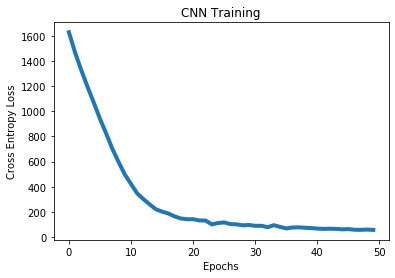

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(loss_hist,linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("CNN Training")
plt.show()
plt.savefig("CNN_training.png")

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))
clf.fit(train_X.reshape([train_X.shape[0], -1]), train_Y)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [4]:
pred = clf.predict(test_X.reshape([test_X.shape[0], -1]))



In [6]:
np.sum(np.equal(pred, test_Y)) / len(test_Y)

0.4410512227764935

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(test_X, label = test_Y)

param = {'objective': 'multi:softmax',
         'num_class': 8,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [ ]:
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)

In [ ]:
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))
confMatrix3 = confusion_matrix(y_test, y_pred_xgb)
print('Confusion matrix for XGB:')
fig, ax = plot_confusion_matrix(confMatrix3)
plt.show()